In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import v2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel
from transformers.models.vit.modeling_vit import ViTIntermediate

In [2]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Read datasets

In [3]:
root_dir = 'datasets/nsfw_dataset_v1'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [4]:
class_names = [
    "drawings",
    "hentai",
    "neutral",
    "porn",
    "sexy"
]

# Split datasets

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Build PyTorch Dataset

In [6]:
class NsfwDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
            
        return img, self.labels[idx]

# Preprocessing datasets

In [7]:
feature_extractor = ViTImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")

image_mean = feature_extractor.image_mean
image_std = feature_extractor.image_std
image_height = feature_extractor.size['height']
image_width = feature_extractor.size['width']

In [8]:
def transform(img):
    augmentation = v2.Compose([
        v2.Resize((image_height, image_width)),
        v2.RandomRotation(30),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize(mean=image_mean,
                             std=image_std),
    ])

    img_transformed = augmentation(img)
    return img_transformed

def test_transform(img):
    augmentation = v2.Compose([
        v2.Resize((image_height, image_width)),
        v2.ToTensor(),
        v2.Normalize(mean=image_mean,
                             std=image_std),
    ])

    img_transformed = augmentation(img)
    return img_transformed

# Build DataLoader

In [9]:
train_dataset = NsfwDataset(
    X_train, y_train,
    transform=transform,
)
val_dataset = NsfwDataset(
    X_val, y_val,
    transform=test_transform
)
test_dataset = NsfwDataset(
    X_test, y_test,
    transform=test_transform
)

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(19600, 5600, 2800)

In [10]:
train_batch_size = 256
test_batch_size = 256

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True,pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False,pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,drop_last=False,pin_memory=True
)

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


# Plot data function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow 

torch.Size([256, 224, 224, 3])


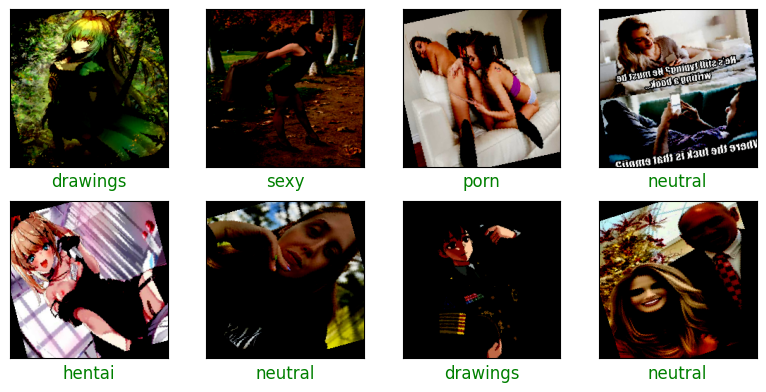

In [12]:
from typing import Optional
def plot_data(x_data: np.ndarray, y_data: np.ndarray,
              y_proba: Optional[np.ndarray] = None) -> None:
  nrows, ncols = 2, 4
  len_x = x_data.shape[0]
  fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4))
  for i in range (nrows*ncols):
    ax = axes[i // ncols, i % ncols]
    color = 'green'
    index_img = random.randint(0,len_x)
    ax.imshow(x_data[index_img])
    true_label_str = class_names[y_data[index_img]]
    if y_proba is not None:
      predicted_index = np.argmax(y_proba[index_img])
      predicted_label = class_names[predicted_index]
      color = 'red' if predicted_index != y_data[index_img] else color
      predicted_label_str = "\nPredicted: " + predicted_label

    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str

    ax.set_xlabel(img_title, color = color, fontsize = 12)
    ax.set(xticks=[],yticks=[])
  plt.tight_layout()
  plt.show()
  
img = train_features.permute(0, 2, 3, 1)
print(img.shape)
label = train_labels
plot_data(img, label)

# Fine-tuning model

In [14]:
id2label = {id:label for id, label in enumerate(class_names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'drawings', 1: 'hentai', 2: 'neutral', 3: 'porn', 4: 'sexy'}

In [143]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(class_names)
vit_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-tiny-patch16-224",
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    attention_probs_dropout_prob=0.05,
).to(device)

for param in vit_model.parameters():
    param.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([5, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(vit_model.vit.encoder)

ViTEncoder(
  (layer): ModuleList(
    (0-11): 12 x ViTLayer(
      (attention): ViTSdpaAttention(
        (attention): ViTSdpaSelfAttention(
          (query): Linear(in_features=192, out_features=192, bias=True)
          (key): Linear(in_features=192, out_features=192, bias=True)
          (value): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (output): ViTSelfOutput(
          (dense): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): ViTIntermediate(
        (dense): Linear(in_features=192, out_features=768, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): ViTOutput(
        (dense): Linear(in_features=768, out_features=192, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm_before): LayerNorm((192,), eps=1e-12, elementwise_affine=True)
      (la

In [123]:
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [129]:
class SoftMoe(nn.Module):
    """
    Soft Mixture of Experts (SoftMoE) implementation as described in:
    "From Sparse to Soft Mixtures of Experts" by Joan Puigcerver, Carlos Riquelme,
    Basil Mustafa, Neil Houlsby at Google DeepMind.

    The soft MoE is neither sparse, nor dense, but a mixture.
    The input activates all experts as in a dense MoE,
    but it is done so only fractionally as in a sparse MoE.

    This class provides a fully-differentiable sparse Transformer that addresses
    challenges in MoEs like training instability, token dropping, inability to scale
    the number of experts, or ineffective fine-tuning.

    https://arxiv.org/abs/2308.00951
    """

    def __init__(
        self,
        n_experts,
        n_slots_per_expert,
        input_dim,
        hidden_dim,
        pretrained_weight_intermediate=None, 
        pretrained_weight_output=None
    ):
        super().__init__()
        self.n_experts = n_experts
        self.n_slots_per_expert = n_slots_per_expert
        self.embed_dim = input_dim
        self.experts = nn.ModuleList(
            [Expert(input_dim, hidden_dim) for _ in range(self.n_experts)]
        )
        # Nếu có trọng số pretrained, load cho từng expert
        if pretrained_weight_intermediate is not None and pretrained_weight_output is not None:
            for expert in self.experts:
                with torch.no_grad():
                    # expert.network[0]: Linear(192,768)
                    expert.network[0].weight.copy_(pretrained_weight_intermediate['weight'])
                    expert.network[0].bias.copy_(pretrained_weight_intermediate['bias'])
                    # expert.network[3]: Linear(768,192)
                    expert.network[3].weight.copy_(pretrained_weight_output['weight'])
                    expert.network[3].bias.copy_(pretrained_weight_output['bias'])

        self.phi = nn.Parameter(
            torch.randn(self.embed_dim, self.n_experts * self.n_slots_per_expert)
        )

    def forward(self, x: torch.Tensor):
        logits = torch.matmul(x, self.phi)  # (batch_size, seq_len, slots)
        dispatch_weights = F.softmax(logits, dim=-1)
        combine_weights = F.softmax(logits, dim=1)
        xs = torch.bmm(dispatch_weights.transpose(1, 2), x)
        ys = torch.cat(
            [
                expert(
                    xs[
                        :,
                        i * self.n_slots_per_expert : (i + 1) * self.n_slots_per_expert,
                        :,
                    ]
                )
                for i, expert in enumerate(self.experts)
            ],
            dim=1,
        )
        y = torch.bmm(combine_weights, ys)
        return y

In [ ]:
class CustomIdentity(nn.Module):
    def forward(self, x, *args, **kwargs):
        return x

In [132]:
class MoEViTIntermediate(ViTIntermediate):
    def __init__(self, config, pretrained_weight_intermediate, pretrained_weight_output):
        super().__init__(config)
        
        # Load trọng số từ lớp dense cũ vào các expert
        self.dense = SoftMoe(
            n_experts=8,
            n_slots_per_expert=2,
            input_dim=config.hidden_size,
            hidden_dim=config.intermediate_size,
            pretrained_weight_intermediate=pretrained_weight_intermediate,
            pretrained_weight_output=pretrained_weight_output,
        ).to(device)

        self.intermediate_act_fn = CustomIdentity()

    def forward(self, hidden_states):
        # hidden_states: [B, T, 192]
        moe_out = self.dense(hidden_states)  # [B, T, 192] bởi vì Expert có kiến trúc 192->768->192
        # Skip connection: cộng đầu vào với đầu ra MoE
        out = hidden_states + moe_out
        return out

In [133]:
for i in range(len(vit_model.vit.encoder.layer)):
    pretrained_weight_intermediate = {
        "weight": vit_model.vit.encoder.layer[i].intermediate.dense.weight.data.clone(),
        "bias": vit_model.vit.encoder.layer[i].intermediate.dense.bias.data.clone(),
    }
    pretrained_weight_output = {
        "weight": vit_model.vit.encoder.layer[i].output.dense.weight.data.clone(),
        "bias": vit_model.vit.encoder.layer[i].output.dense.bias.data.clone(),
    }
    # Thay thế module intermediate bằng MoEViTIntermediate đã kết hợp cả hai phần
    vit_model.vit.encoder.layer[i].intermediate = MoEViTIntermediate(
        vit_model.config, pretrained_weight_intermediate, pretrained_weight_output)
    # Đặt output của ViT layer thành Identity vì skip connection đã được tích hợp trong MoEViTIntermediate
    vit_model.vit.encoder.layer[i].output = CustomIdentity()

In [134]:
print(vit_model.vit.encoder)

ViTEncoder(
  (layer): ModuleList(
    (0-11): 12 x ViTLayer(
      (attention): ViTSdpaAttention(
        (attention): ViTSdpaSelfAttention(
          (query): Linear(in_features=192, out_features=192, bias=True)
          (key): Linear(in_features=192, out_features=192, bias=True)
          (value): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
        )
        (output): ViTSelfOutput(
          (dense): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): MoEViTIntermediate(
        (dense): SoftMoe(
          (experts): ModuleList(
            (0-7): 8 x Expert(
              (network): Sequential(
                (0): Linear(in_features=192, out_features=768, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.1, inplace=False)
                (3): Linear(in_features=768, out_features=192, bias=

In [ ]:
vit_model.vit.encoder.layer[0].intermediate.dense.experts[0].network[0].weight

In [146]:
vit_model.eval()
dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = vit_model(dummy_tensor)

print('Output shape:', output)

Output shape: ImageClassifierOutput(loss=None, logits=tensor([[-1.7310, -1.6289,  0.1191, -0.6546, -0.0068]], device='cuda:0'), hidden_states=None, attentions=None)


# Training

In [147]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16, cache_enabled=True, enabled=True):
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [148]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    scheduler
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        correct = 0
        total = 0
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16, cache_enabled=True, enabled=True):
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        train_epoch_acc = correct / total

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_epoch_acc:.4f},\
           Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    torch.cuda.empty_cache()
    return train_losses, val_losses

In [149]:
lr = 2e-4
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    vit_model.parameters(),
    lr=lr,
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.9,
)

In [ ]:
# checkpoint = torch.load("checkpoint_epoch15.pt")

# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# if 'scheduler_state_dict' in checkpoint:
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


In [150]:
train_losses, val_losses = fit(
    vit_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    5,
    scheduler
)

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch: 1, Train Loss: 0.4797, Train Acc: 0.8126,           Val Loss: 0.2995, Val Acc: 0.8832
Epoch: 2, Train Loss: 0.2648, Train Acc: 0.8997,           Val Loss: 0.2686, Val Acc: 0.9016


KeyboardInterrupt: 

In [142]:
torch.cuda.empty_cache()

# Evaluation

In [27]:
test_loss, test_acc = evaluate(
    vit_model,
    test_loader,
    criterion,
    device
)

print('Evaluation on test dataset')
print('Test accuracy: ', test_acc)

Evaluation on test dataset
Test accuracy:  0.9171428571428571


In [ ]:
torch.save(vit_model, "model/vit_tiny_nsfw.pt")

In [ ]:
model = torch.load("model/vit_tiny_nsfw.pt", weights_only=False, map_location="cpu")
model.eval()
dummy_tensor = torch.rand((1, 3, 224, 224))

with torch.no_grad():
    output = model(dummy_tensor).logits

print('Output shape:', output)

max = torch.argmax(output, dim=1)
class_names[max]

Output shape: tensor([[ 1.7404,  0.2298,  1.4318, -1.8798, -0.6741]])


'drawings'

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits  # Chỉ lấy logits làm đầu ra

wrapped_model = ModelWrapper(model)
wrapped_model.eval()

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(wrapped_model, example, strict=False)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model/vit_tiny_nsfw_mobile.pt")

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\models\vit\modeling_vit.py:163: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\models\vit\modeling_vit.py:169: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might

In [ ]:
# Kiểm tra mô hình đã lưu
loaded_model = torch.jit.load("model/vit_tiny_nsfw_mobile.pt")
loaded_model.eval()

test_tensor = torch.rand(1, 3, 224, 224)
output = loaded_model(test_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 5])


torch.Size([1, 3, 224, 224])